In [35]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import visualize_tsne_model

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# datasets for t-SNE examples
from tensorflow.keras.datasets import mnist, fashion_mnist

plt.style.use('seaborn-darkgrid')

In [9]:
data = pd.read_csv('../datasets/Mall_Customers.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Exploratory Data Analysis

### Distribution of age by gender

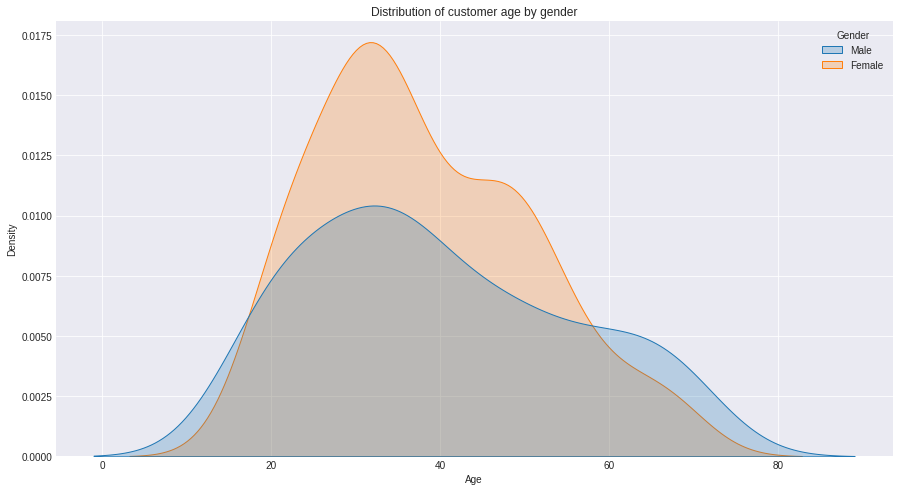

In [25]:
'''
    Generally the customers from both genders lessen over age but females
    dominates males in the age range from 20 to 40
'''
fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=data, x='Age', hue='Gender', fill=True, ax=ax)

ax.set_title('Distribution of customer age by gender')
plt.show()

### Distribution of income by gender

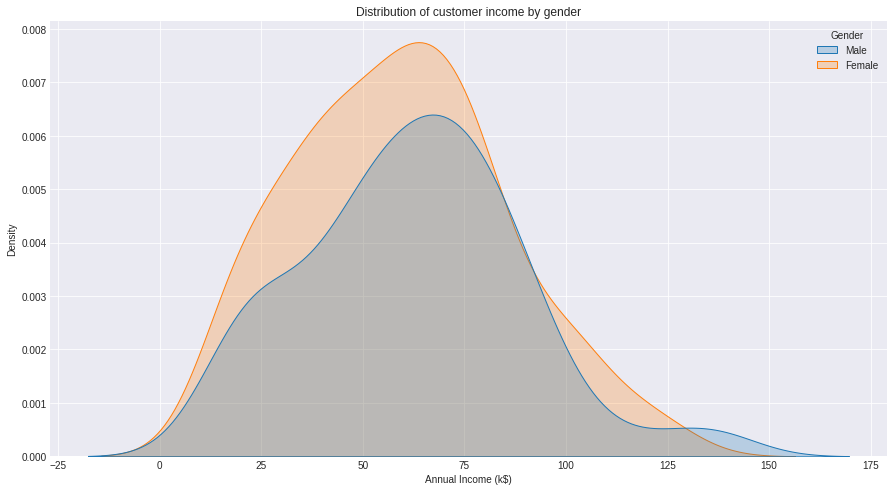

In [32]:
'''
    Generally no difference in income between the two group but those of extremely high 
    income are more likely to be males judging by the tails of the two distributions.
    You can implement an one-way ANOVA or an independent t-test to justify this.
'''
fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=data, x='Annual Income (k$)', hue='Gender', fill=True, ax=ax)

ax.set_title('Distribution of customer income by gender')
plt.show()

### Joint distribution of spending score and annual income by genders

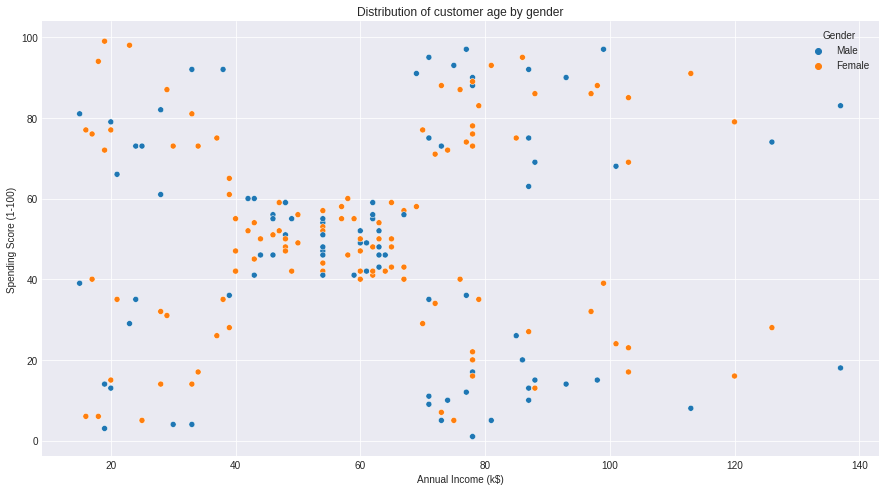

In [30]:
'''
    This is where it transitions into why we need segmentation techniques.
    From this scatterplot, it can be seen that we cannot segment our customers
    by genders because it seems irrelevant to their spending habits. 
    Again, you can use independent t-test to justify this.
'''
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', ax=ax)

ax.set_title('Distribution of customer age by gender')
plt.show()

# Clustering : K-Means
- K-Means is a simple and popular clustering technique. It is widely used because of the simplicity and the high speed. 
- Implementation:
    - Before we do anything in K-Means, we need to select the number of clusters that we want to identify. That is, essentially the K value in the name "K-Means".
    - Then, we randomly initialize K data points as the centroids of each cluster.
    - After that, for every point in our dataset, we assign the data point to a cluster based on which cluster centroid is the nearest to them.
    - Then, we should have K clusters in our dataset. Now, we should update the cluster centroids by taking the mean of datapoints in every cluster.
    - We will keep doing that until the cluster centroids can no longer be updated.
    - K-Means simulation : [Link](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

### Example of K-Means

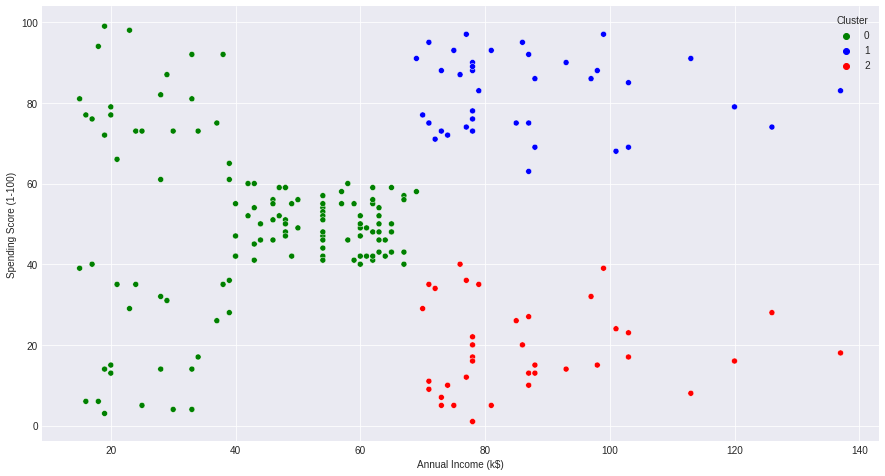

In [52]:
# Example of using K-Means on annual income and spending score
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['Annual Income (k$)', 'Spending Score (1-100)']])
data['Cluster'] = kmeans.predict(data[['Annual Income (k$)', 'Spending Score (1-100)']])

# Visualize the cluster
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', ax=ax, palette=['green', 'blue', 'red'])

plt.show()

### Choosing right number of K - Within cluster sum squares
 - Within cluster sum-squares is the measure of variance within each cluster. The higher the number of K, the lower the wcss. However, it is not the case that the lower the wcss the better. We don't want to make cluster too small or too big, just enough to discriminate the data points. 
 - WCSS formular:
 
     # $WCSS = \sum \limits_{c_k \in C} \sum \limits_{d_i \in c_k} distance(d_i, centroid_k)$

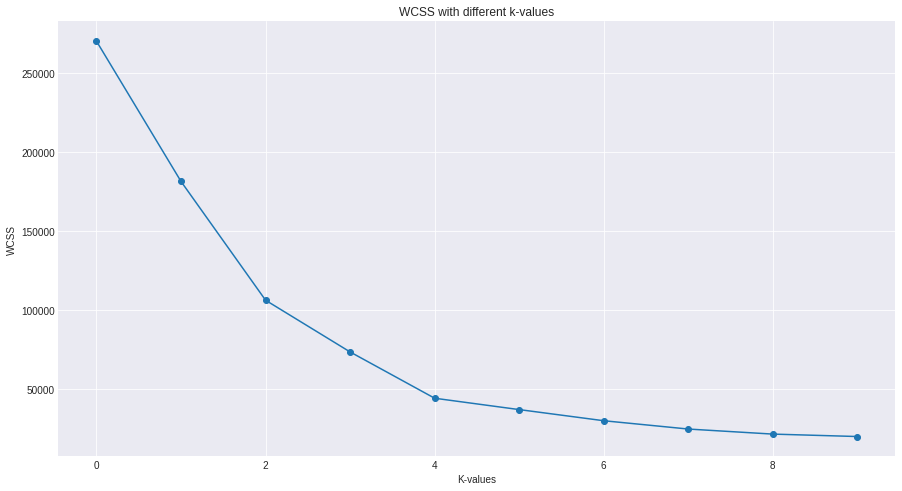

In [51]:
k_values = list(range(1, 11))
wcss = []
features = data[['Annual Income (k$)', 'Spending Score (1-100)']]

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(wcss, marker='o')
plt.title("WCSS with different k-values")
plt.xlabel('K-values')
plt.ylabel("WCSS")
plt.show()

Let's choose k = 5

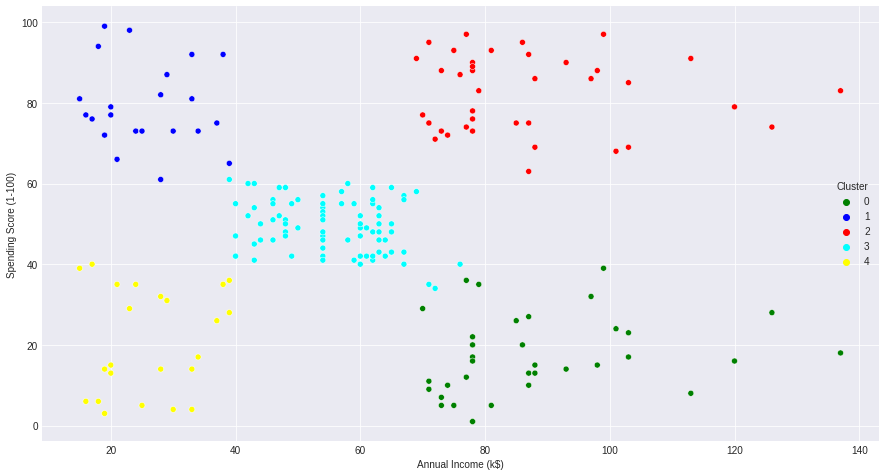

In [54]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
data['Cluster'] = kmeans.predict(features)

# Visualize the cluster
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', ax=ax, palette=['green', 'blue', 'red', 'cyan', 'yellow'])

plt.show()

### Extract the characteristics of the clusters

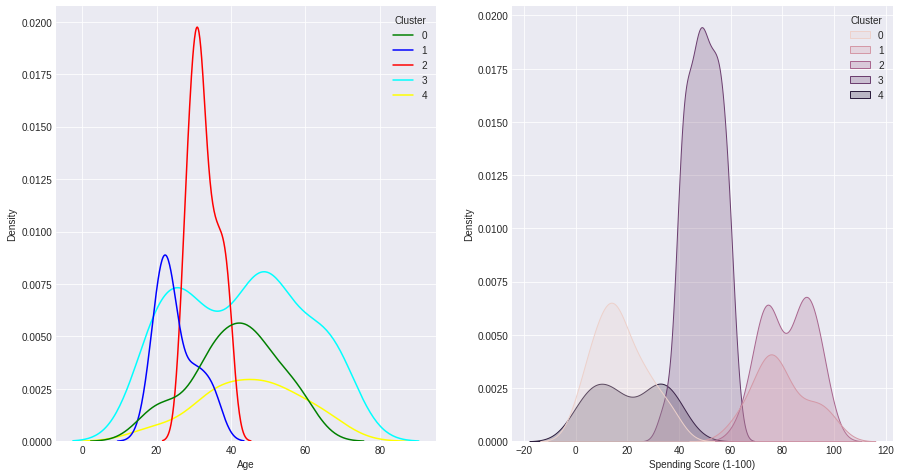

In [68]:
# How does the age distribute over the clusters?
# Let's compare the age with the spending score

'''
    It can be seen that the most common group of customers is from cluster number 3. However,
    this cluster is not the one with most spending powers. The ones with most spending power
    is clusters 1 and 2. And if you reflect back to the distribution of age, the clusters 1 and 2
    are actually relatively young. So you can conclude that the most prominent segment of customers
    are in the range of 20s to 40s because they have the most spending power.
'''

fig, ax = plt.subplots(1,2, figsize=(15, 8))

sns.kdeplot(data=data, x='Age', hue='Cluster', palette=['green', 'blue', 'red', 'cyan', 'yellow'], ax=ax[0])
sns.kdeplot(data=data, x='Spending Score (1-100)', hue='Cluster', fill=True, ax=ax[1])
plt.show()

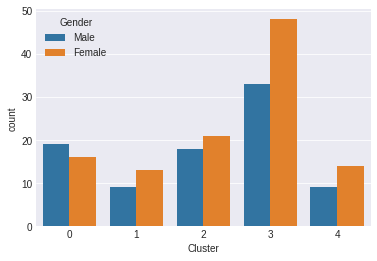

In [61]:
# Gender count by each cluster
sns.countplot(data=data, x='Cluster', hue='Gender')
plt.show()

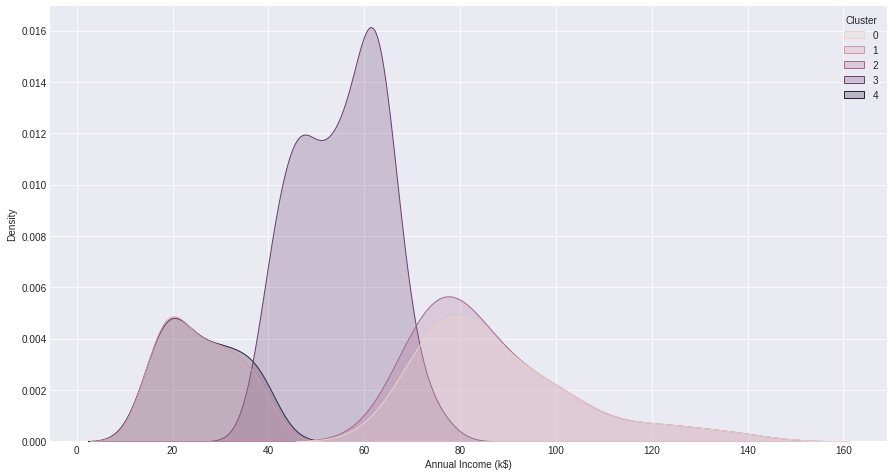

In [64]:
# Annual income by clusters
fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=data, x='Annual Income (k$)', hue='Cluster', fill=True, ax=ax)
plt.show()

# Dimensionality reduction : introduction to PCA
 - Dimensionality reduction is another unsupervised machine learning method. This category of algorithms can be divided into two subcategories - **Matrix factorization (decomposition)** or **Neighbor Graph** (Which we won't talk about today). Principal component analysis is of the former.
 - Principal component analysis intuition : Given a dataset, we would like to find a line, or a plane, or a hyperplane such that when we project all of our data onto it, the information about the data is retained as much as possible.
**(Explain using canvas)**

### PCA examples in the wine dataset

In [69]:
# Let's import the wine dataset
data = pd.read_csv('../datasets/wine.csv')
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [75]:
# To perform PCA, the first thing you need to do is rescale your features
# 1. Extract the features columns
columns = list(data.columns)
columns.remove('Class')

# 2. Extract the features and scale them
features = data[columns]
features = StandardScaler().fit_transform(features)
features = pd.DataFrame(data=features, columns=columns)
features.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [76]:
# 3. Construct a PCA model with 3 principal components
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)
data['pc_1'] = pca_features[:, 0]
data['pc_2'] = pca_features[:, 1]
data['pc_3'] = pca_features[:, 2]

data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,pc_1,pc_2,pc_3
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,3.316751,-1.443463,-0.165739
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2.209465,0.333393,-2.026457
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2.516740,-1.031151,0.982819
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,3.757066,-2.756372,-0.176192
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1.008908,-0.869831,2.026688


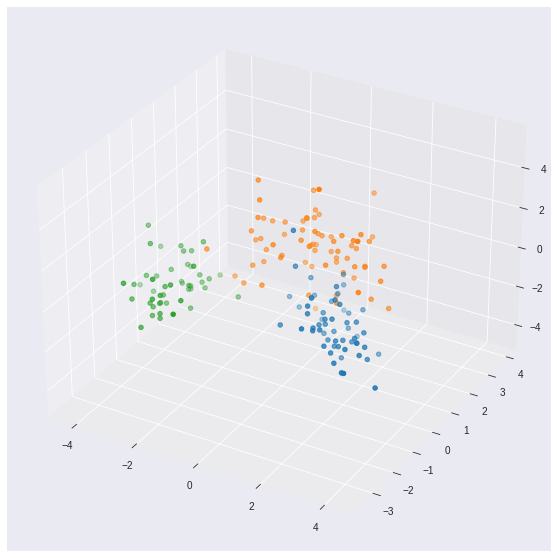

In [79]:
# 4. Visualize the principal components in 3D space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(data['Class']):
    cluster = data[data['Class'] == label]
    ax.scatter3D(cluster['pc_1'], cluster['pc_2'], cluster['pc_3'])
    
plt.show()

### Explained variance ratio
- Explained variance ratio in PCA tells us how much information about the variance of the dataset each principal component holds in percentage.

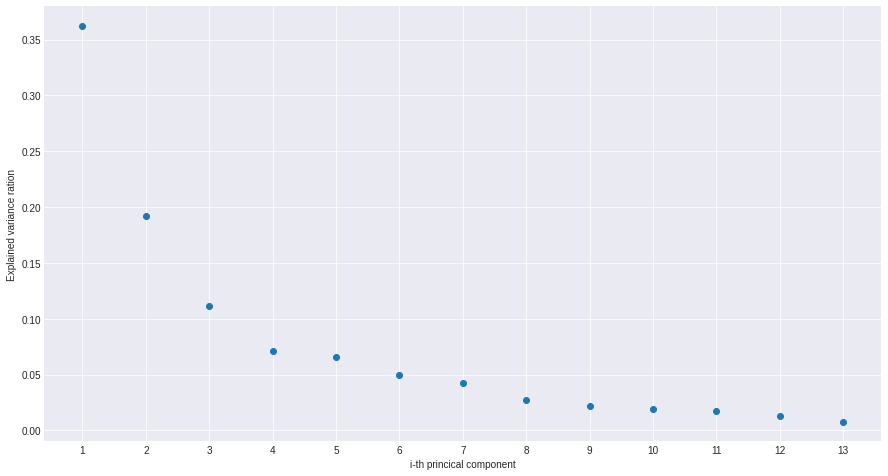

In [81]:
pca = PCA(n_components=None)
pca.fit(features)
evr = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(x = [i+1 for i in range(len(evr))],
           y = evr)
plt.xticks([i+1 for i in range(len(evr))])
plt.xlabel('i-th princical component')
plt.ylabel('Explained variance ration')
plt.show()